In [1]:
import os
#os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
#os.environ["CUDA_VISIBLE_DEVICES"] = "2,3"

import numpy as np
from tqdm import tqdm, trange
from matplotlib import pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds

tf.config.optimizer.set_jit(True)
tf.config.optimizer.set_experimental_options({"auto_mixed_precision": True})

from nvstatsrecorder.callbacks import NVStats, NVLinkStats

from xfmers import models
from xfmers import utils
from xfmers import ops

In [2]:
MAX_SEQ_LEN = 80
BATCH_SIZE = 640
EPOCHS = 10
BUFFER_SIZE = 10000000

NUM_LAYERS = 4
NUM_HEADS = 8
D_MODEL = NUM_HEADS * 64
FF_UNITS = D_MODEL * 4
DROPOUT = 0.01
WEIGHT_SHARING = False
EFFICIENT_ATTENTION = False
SHARED_QK = False
CONV_FILTER = 1
CONV_PADDING = "same"
ACTIVATION = ops.gelu
REVERSIBLE = False
FUSED_QKV = False
CAUSAL = True

strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))
BATCH_SIZE *= strategy.num_replicas_in_sync
print("Batch size:", BATCH_SIZE)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
Number of devices: 4
Batch size: 2560


In [3]:
def load_text8(text8_path, num_char=None):
    with open(text8_path, 'r', encoding="utf8") as file:
        data = file.read().replace('\n', ' ').strip()
        data = data.replace("  ", " ")
    if num_char:
        data = data[:num_char]
    return data.strip()

text_8_train = load_text8("./data/train.txt.raw")
char_set = list(set(list(text_8_train)))
char_set.sort()
print("Character set:", char_set)
len_corpus = len(text_8_train)

tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=len(char_set)+1, char_level=True)
tokenizer.fit_on_texts(["".join(char_set)])

VOCAB_SIZE = tokenizer.num_words + 1
print("Vocab size:", VOCAB_SIZE)

# pad to 8
vocab_size_mult = VOCAB_SIZE // 8
vocab_size_r = VOCAB_SIZE % 8
if vocab_size_r > 0:
    VOCAB_SIZE = (vocab_size_mult + 1) * 8
    print("Vocab size padded to:", VOCAB_SIZE, "(performance reasons)")

Character set: [' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Vocab size: 29
Vocab size padded to: 32 (performance reasons)


In [4]:
def prepare_sequences(corpus, tokenizer, interval=1, seq_len=512):
    """Tokenize, filter and pad sentences"""
    print("Encoding corpus...")
    print(corpus[:MAX_SEQ_LEN])
    corpus = tokenizer.texts_to_sequences([corpus])[0]
    print(corpus[:MAX_SEQ_LEN])
    total_words = len(corpus)
    print("Done! Token count:", total_words)
    print("Generating sequences...")
    list_seq = []
    for i in trange(0, total_words-seq_len, interval):
        seq = corpus[i:i+seq_len+1]
        list_seq.append(seq)
    print("Done!")
    return np.asarray(list_seq, dtype="int")

list_seq = prepare_sequences(text_8_train, tokenizer, interval=5, seq_len=MAX_SEQ_LEN)

del text_8_train

print("Training sequences:", list_seq.shape)

Encoding corpus...
anarchism originated as a term of abuse first used against early working class r
[2, 15, 2, 19, 4, 9, 10, 20, 14, 1, 16, 19, 10, 8, 10, 15, 2, 21, 6, 5, 1, 2, 20, 1, 2, 1, 21, 6, 19, 14, 1, 16, 7, 1, 2, 3, 22, 20, 6, 1, 7, 10, 19, 20, 21, 1, 22, 20, 6, 5, 1, 2, 8, 2, 10, 15, 20, 21, 1, 6, 2, 19, 13, 26, 1, 24, 16, 19, 12, 10, 15, 8, 1, 4, 13, 2, 20, 20, 1, 19]
Done! Token count: 89999999
Generating sequences...


100%|██████████| 17999984/17999984 [01:16<00:00, 235009.87it/s]

Done!
Training sequences: (17999984, 81)


In [5]:
text_8_val = load_text8("./data/valid.txt.raw")

list_seq_val = prepare_sequences(text_8_val, tokenizer, interval=30, seq_len=MAX_SEQ_LEN)

del text_8_val

print("Validation sequences:", list_seq_val.shape)

Encoding corpus...
e the capital of one government after another one of such governments was establ


 70%|██████▉   | 115912/166664 [00:00<00:00, 535724.02it/s]

[6, 1, 21, 9, 6, 1, 4, 2, 17, 10, 21, 2, 13, 1, 16, 7, 1, 16, 15, 6, 1, 8, 16, 23, 6, 19, 15, 14, 6, 15, 21, 1, 2, 7, 21, 6, 19, 1, 2, 15, 16, 21, 9, 6, 19, 1, 16, 15, 6, 1, 16, 7, 1, 20, 22, 4, 9, 1, 8, 16, 23, 6, 19, 15, 14, 6, 15, 21, 20, 1, 24, 2, 20, 1, 6, 20, 21, 2, 3, 13]
Done! Token count: 4999999
Generating sequences...


100%|██████████| 166664/166664 [00:00<00:00, 593528.01it/s]


Done!
Validation sequences: (166664, 81)


In [6]:
# training

dataset = tf.data.Dataset.from_tensor_slices(({'inputs': list_seq[:,:-1]},
                                              {'outputs': list_seq[:,-1]},))
dataset = dataset.repeat(-1)
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(32)
_ = dataset.take(1)

# validation

val_dataset = tf.data.Dataset.from_tensor_slices(({'inputs': list_seq_val[:,:-1]},
                                                  {'outputs': list_seq_val[:,-1]},))
val_dataset = val_dataset.repeat(-1)
val_dataset = val_dataset.shuffle(BUFFER_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.prefetch(32)
_ = val_dataset.take(1)

train_steps = int(list_seq.shape[0]/BATCH_SIZE)
valid_steps = int(list_seq_val.shape[0]/BATCH_SIZE)

print("Train for", train_steps)
print("Valid for", valid_steps)

Train for 7031
Valid for 65


In [12]:
with strategy.scope():
    model = models.Transformer(
        vocab_size=VOCAB_SIZE,
        dec_layers=NUM_LAYERS,
        ff_units=FF_UNITS,
        d_model=D_MODEL,
        num_heads=NUM_HEADS,
        dropout=DROPOUT,
        max_seq_len=MAX_SEQ_LEN,
        weight_sharing=WEIGHT_SHARING,
        efficient_attention=EFFICIENT_ATTENTION,
        shared_qk=SHARED_QK,
        activation=ACTIVATION,
        reversible=REVERSIBLE,
        fused_qkv=FUSED_QKV,
        causal=CAUSAL
    )
    epoch_div_2 = int(EPOCHS/2)
    learning_rate = utils.WarmupExpDecay(
        epoch_steps=train_steps,
        base_lr=1e-4,
        min_lr=1e-8,
        decay_exp=2,
        warmup_epochs=1,
        flat_epochs=EPOCHS-3,
        max_epochs=EPOCHS,
    )
    opt = tf.keras.optimizers.Adam(learning_rate, epsilon=1e-8)
    opt = tf.keras.mixed_precision.experimental.LossScaleOptimizer(opt, "dynamic")
    lossfn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    acc = tf.keras.metrics.SparseCategoricalAccuracy(name="acc")
    model.compile(optimizer=opt,
                  loss=lossfn,
                  metrics=[acc, utils.bpc])

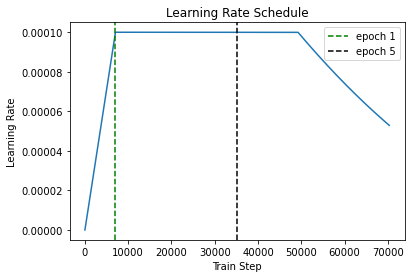

In [13]:
plt.plot(learning_rate(tf.range(train_steps*EPOCHS, dtype=tf.float32)))
plt.axvline(train_steps, linestyle="--",  color="g", label="epoch 1")
plt.axvline(train_steps*epoch_div_2, linestyle="--", color="k", label="epoch "+str(epoch_div_2))
plt.title("Learning Rate Schedule")
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")
plt.legend()
plt.show()

In [14]:
model.summary()

Model: "Transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
PaddingMaskGenerator (PaddingMa (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
TokenPosEmbedding (TokenPosEmbe (None, None, 512)    57344       inputs[0][0]                     
__________________________________________________________________________________________________
DecoderBlock (TransformerStack) (None, None, 512)    18900992    PaddingMaskGenerator[0][0]       
                                                                 TokenPosEmbedding[0][0]

In [15]:
nv_stats = NVStats(gpu_index=3, interval=15)
nvlink_stats = NVLinkStats("volta", gpus=[0,1,2,3], interval=15)
time_history = utils.TimeHistory(eg_per_epoch=train_steps*BATCH_SIZE)
callbacks = [
    time_history,
#    nv_stats,
#    nvlink_stats
]

[NVLinkStats] Watching: [0, 1, 2, 3]


In [ ]:
with strategy.scope():
    model.fit(dataset, epochs=EPOCHS, steps_per_epoch=train_steps,
              validation_data=val_dataset, validation_steps=valid_steps,
              verbose=1, callbacks=callbacks)
    
epoch_time = min(time_history.times)
tokens_per_epoch = BATCH_SIZE*train_steps*MAX_SEQ_LEN
print("Tokens/sec:", int(tokens_per_epoch/epoch_time))

Train for 7031 steps, validate for 65 steps
Epoch 1/10
INFO:tensorflow:batch_all_reduce: 52 all-reduces with algorithm = nccl, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10
INFO:tensorflow:batch_all_reduce: 52 all-reduces with algorithm = nccl, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10
7030/7031 [============================>.] - ETA: 0s - loss: 1.7159 - acc: 0.4750 - bpc: 2.4755
Eg/sec: 13703
7031/7031 [==============================] - 1313s 187ms/step - loss: 1.7158 - acc: 0.4750 - bpc: 2.4754 - val_loss: 1.3498 - val_acc: 0.5784 - val_bpc: 1.9474
Epoch 2/10
7030/7031 [============================>.] - ETA: 0s - loss: 1.3184 - acc: 0.5857 - bpc: 1.9021
Eg/sec: 14649
7031/7031 [==============================] - 1229s 175ms/step - loss: 1.3184 - acc: 0.5857 - bpc: 1.9021 - val_loss: 1.2636 - val_acc: 0.6023 - val_bpc: 1.8231
Epoch 3/10
7030/7031 [============================>.] - ETA: 0s - loss: 1.2545 - acc: 0.60

In [ ]:
#nv_stats_recorder = nv_stats.recorder
#nv_stats_recorder.plot_gpu_util(smooth=10)

In [ ]:
#nvlink_stats_recorder = nvlink_stats.recorder
#nvlink_stats_recorder.plot_nvlink_traffic(smooth=10)